In [78]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
from torch.utils.data import Dataset, DataLoader


In [79]:
# Load bounding boxes (detection)
df_detection = pd.read_csv('Licplatesdetection_train.csv')
display(df_detection.head())


,img_id,ymin,xmin,ymax,xmax
0,1.jpg,276,94,326,169
1,10.jpg,311,395,344,444
2,100.jpg,406,263,450,434
3,101.jpg,283,363,315,494
4,102.jpg,139,42,280,222


In [80]:
# Load plate text (recognition)
df_recognition = pd.read_csv('Licplatesrecognition_train.csv')
display(df_recognition.head())


,img_id,text
0,0.jpg,117T3989
1,1.jpg,128T8086
2,10.jpg,94T3458
3,100.jpg,133T6719
4,101.jpg,68T5979


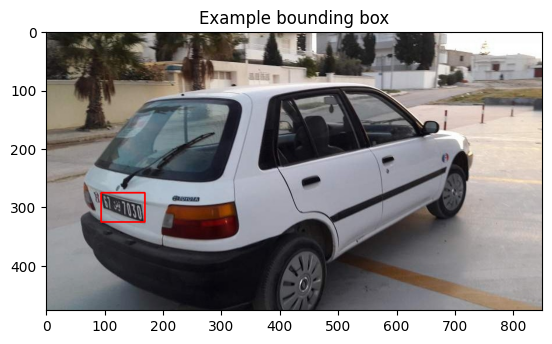

In [81]:
img_folder = './license_plates_detection_train/' # update if different
sample = df_detection.iloc[0]
img = cv2.imread(os.path.join(img_folder, sample['img_id']))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.rectangle(
    img,
    (sample['xmin'], sample['ymin']),
    (sample['xmax'], sample['ymax']),
    (255,0,0), 2
)
plt.imshow(img)
plt.title('Example bounding box')
plt.show()


In [82]:
class DetDataset(Dataset):
    def __init__(self, df, img_dir, tfm=None):
        self.df = df
        self.ids = df['img_id'].tolist()
        self.img_dir = img_dir
        self.tfm = tfm

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['img_id'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        box = [row['xmin'], row['ymin'], row['xmax'], row['ymax']] # Note order!
        if self.tfm:
            img = self.tfm(img)
        return img, box

# Example usage:
# det_ds = DetDataset(df_detection, './license_plates_detection_train/')
# img, box = det_ds[0]


In [83]:
class RecogDataset(Dataset):
    def __init__(self, df, img_dir, tfm=None):
        self.df = df
        self.ids = df['img_id'].tolist()
        self.labels = df['label'].tolist()
        self.img_dir = img_dir
        self.tfm = tfm

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.ids[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        if self.tfm:
            img = self.tfm(img)
        return img, label

# Example usage:
# ocr_ds = RecogDataset(df_recognition, './license_plates_recognition_train/')
# img, text = ocr_ds[0]


In [84]:
def convert_bbox(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[2]) / 2.0
    y = (box[1] + box[3]) / 2.0
    w = box[2] - box[0]
    h = box[3] - box[1]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

img_dir = './license_plates_detection_train/'
labels_dir = './yolo_labels/'
os.makedirs(labels_dir, exist_ok=True)
for i, row in tqdm(df_detection.iterrows(), total=len(df_detection)):
    img_path = os.path.join(img_dir, row['img_id'])
    assert os.path.exists(img_path)
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    bbox = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
    yolo_bbox = convert_bbox((w,h), bbox)
    label_line = f"0 {yolo_bbox[0]} {yolo_bbox[1]} {yolo_bbox[2]} {yolo_bbox[3]}"
    txt_path = os.path.join(labels_dir, row['img_id'].replace('.jpg','.txt'))
    with open(txt_path,'w') as f:
        f.write(label_line)


  0%|          | 0/900 [00:00<?, ?it/s]

In [85]:
# Directory containing vehicle images
det_img_dir = './license_plates_detection_train/'

# Output directory for cropped plate images (for recognition training)
os.makedirs('./cropped_plates_train', exist_ok=True)

for i, row in df_detection.iterrows():
    img_path = os.path.join(det_img_dir, row['img_id'])
    img = cv2.imread(img_path)
    if img is None:
        print(f"Image missing: {row['img_id']}")
        continue
    ymin, xmin, ymax, xmax = int(row['ymin']), int(row['xmin']), int(row['ymax']), int(row['xmax'])
    crop = img[ymin:ymax, xmin:xmax]
    out_path = os.path.join('./cropped_plates_train', row['img_id'])
    cv2.imwrite(out_path, crop)


In [86]:
# Assume recognition CSV uses same 'img_id' filenames as vehicle set
df_ocr = pd.merge(
    df_detection[['img_id']],  # To keep same order as detection images
    df_recognition[['img_id', 'text']],
    on='img_id',
    how='left'
)
df_ocr['crop_path'] = df_ocr['img_id'].apply(lambda x: os.path.join('./cropped_plates_train', x))
# Check
df_ocr.head()


,img_id,text,crop_path
0,1.jpg,128T8086,./cropped_plates_train\1.jpg
1,10.jpg,94T3458,./cropped_plates_train\10.jpg
2,100.jpg,133T6719,./cropped_plates_train\100.jpg
3,101.jpg,68T5979,./cropped_plates_train\101.jpg
4,102.jpg,106T2131,./cropped_plates_train\102.jpg


In [87]:

df_ocr.rename(columns={'text': 'text'}, inplace=True)


In [88]:
df_ocr = df_detection[df_detection['img_id'].isin(df_recognition['img_id'])]


In [89]:
##test purpose

print(df_recognition.columns.tolist())


['img_id', 'text']


In [92]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CroppedPlateOCRDataset(Dataset):
    def __init__(self, df, tfm=None):
        self.df = df
        self.tfm = tfm if tfm else transforms.ToTensor()
        self.labels = df['text'].tolist()
        self.paths = df['img_id'].tolist()
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        img = self.tfm(img)
        label = self.labels[idx]
        return img, label

# Example: using torchvision's Resize, ToTensor
ocr_transform = transforms.Compose([
    transforms.Resize((64, 128)),  # Height, Width
    transforms.ToTensor(),
])

ocr_dataset = CroppedPlateOCRDataset(df_recognition, tfm=ocr_transform)
ocr_loader  = DataLoader(ocr_dataset, batch_size=32, shuffle=True)


In [93]:
print(ocr_dataset)

In [94]:
test_dir = './test'
test_crops = './cropped_plates_test'
os.makedirs(test_crops, exist_ok=True)

for fname in os.listdir(test_dir):
    img_path = os.path.join(test_dir, fname)
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    cx, cy = w//2, h//2
    # Example: take a region, adjust as appropriate for your dataset
    box_w, box_h = int(0.4*w), int(0.1*h)
    xmin = max(cx - box_w//2, 0)
    xmax = min(cx + box_w//2, w)
    ymin = max(cy - box_h//2, 0)
    ymax = min(cy + box_h//2, h)
    crop = img[ymin:ymax, xmin:xmax]
    cv2.imwrite(os.path.join(test_crops, fname), crop)


In [95]:
results = []
for fname in sorted(os.listdir(test_crops)):
    crop_path = os.path.join(test_crops, fname)
    img = cv2.imread(crop_path)
    result = reader.readtext(img, detail=0)
    text = result[0] if result else ''
    results.append({'img_id': fname, 'label': text})

submission = pd.DataFrame(results)
submission.to_csv('submission.csv', index=False)


C:\Python313\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
